In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import timm
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
nltk.download('punkt', quiet=True)

print("✓ All libraries imported")

✓ All libraries imported


In [ ]:
BASE_DIR = '/content/drive/MyDrive/MedicalReportGenerator'
PROCESSED_DIR = os.path.join(BASE_DIR, 'data/processed')
ENHANCED_DIR = os.path.join(BASE_DIR, 'data/images_enhanced')
CHECKPOINT_DIR = os.path.join(BASE_DIR, 'checkpoints')

print("✓ Paths configured")

✓ Paths configured


In [ ]:
test_df = pd.read_csv(os.path.join(PROCESSED_DIR, 'test_data.csv'))
test_df['image_path_enhanced'] = test_df['filename'].apply(
    lambda x: os.path.join(ENHANCED_DIR, x)
)

print(f"✓ Test data loaded: {len(test_df)} samples")

✓ Test data loaded: 615 samples


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(f"✓ Tokenizer loaded")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✓ Tokenizer loaded


In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        self.densenet = timm.create_model('densenet121', pretrained=True, num_classes=0)
        self.projection = nn.Linear(1024, embed_dim)
    def forward(self, x):
        features = self.densenet(x)
        return self.projection(features).unsqueeze(1)

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-np.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerReportGenerator(nn.Module):
    def __init__(self, vocab_size=30522, embed_dim=512, num_heads=8, num_layers=6, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.encoder = ImageEncoder(embed_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim)
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads,
                                                   dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.embed_dim = embed_dim

    def create_causal_mask(self, seq_len, device):
        mask = torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1)
        return mask.masked_fill(mask == 1, float('-inf'))

    def forward(self, images, input_ids, attention_mask=None):
        memory = self.encoder(images)
        tgt = self.embedding(input_ids) * np.sqrt(self.embed_dim)
        tgt = self.pos_encoding(tgt)
        tgt = self.dropout(tgt)
        tgt_mask = self.create_causal_mask(input_ids.size(1), images.device)
        tgt_key_padding_mask = (attention_mask == 0) if attention_mask is not None else None
        output = self.decoder(tgt, memory, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        return self.fc_out(output)

print("✓ Model classes defined")

✓ Model classes defined


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerReportGenerator(vocab_size=tokenizer.vocab_size).to(device)

checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, 'best_model.pt'), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✓ Model loaded from epoch {checkpoint['epoch']}")
print(f"  Val Loss: {checkpoint['val_loss']:.4f}")
print(f"  Device: {device}")

model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

✓ Model loaded from epoch 28
  Val Loss: 0.8104
  Device: cuda


In [ ]:
def generate_report(model, image_path, tokenizer, device, max_length=128):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(Image.fromarray(img_rgb)).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        memory = model.encoder(img_tensor)
        generated = torch.tensor([[tokenizer.cls_token_id]]).to(device)

        for _ in range(max_length):
            tgt_mask = model.create_causal_mask(generated.size(1), device)
            tgt_emb = model.embedding(generated) * np.sqrt(model.embed_dim)
            tgt_emb = model.pos_encoding(tgt_emb)
            tgt_emb = model.dropout(tgt_emb)
            output = model.decoder(tgt_emb, memory, tgt_mask=tgt_mask)
            logits = model.fc_out(output)
            next_token = logits[:, -1, :].argmax(dim=-1)
            generated = torch.cat([generated, next_token.unsqueeze(0)], dim=1)

            if next_token.item() == tokenizer.sep_token_id:
                break

        return img, tokenizer.decode(generated.squeeze(0).cpu().tolist(), skip_special_tokens=True)

print("✓ Generation function ready")
print("\n" + "="*80)
print("✓ SETUP COMPLETE - Ready to run BLEU calculation!")
print("="*80)

✓ Generation function ready

✓ SETUP COMPLETE - Ready to run BLEU calculation!


CALCULATING BLEU SCORES ON TEST SET

Generating reports for 615 test samples...
This will take a few minutes on CPU...



100%|██████████| 615/615 [24:43<00:00,  2.41s/it]



Calculating individual BLEU scores...


100%|██████████| 615/615 [00:00<00:00, 1137.18it/s]



Calculating corpus BLEU scores...

BLEU SCORE RESULTS

📊 CORPUS BLEU SCORES (Overall Model Performance):
  BLEU-1: 0.5581 (55.81%)
  BLEU-2: 0.4873 (48.73%)
  BLEU-3: 0.4483 (44.83%)
  BLEU-4: 0.4163 (41.63%)

📊 AVERAGE SENTENCE BLEU SCORES:
  BLEU-1: 0.5043 ± 0.3027
  BLEU-2: 0.4268 ± 0.3450
  BLEU-3: 0.3824 ± 0.3665
  BLEU-4: 0.3501 ± 0.3790

📊 BLEU-4 STATISTICS:
  Min:     0.0008
  25th %:  0.0319
  Median:  0.1260
  75th %:  0.7291
  Max:     1.0000

📊 LENGTH STATISTICS:
  Avg Reference Length:  44.3 words
  Avg Generated Length:  40.3 words
  Length Ratio:          0.91


/tmp/ipython-input-2779741669.py:163: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(bleu_data, labels=bleu_types, patch_artist=True,


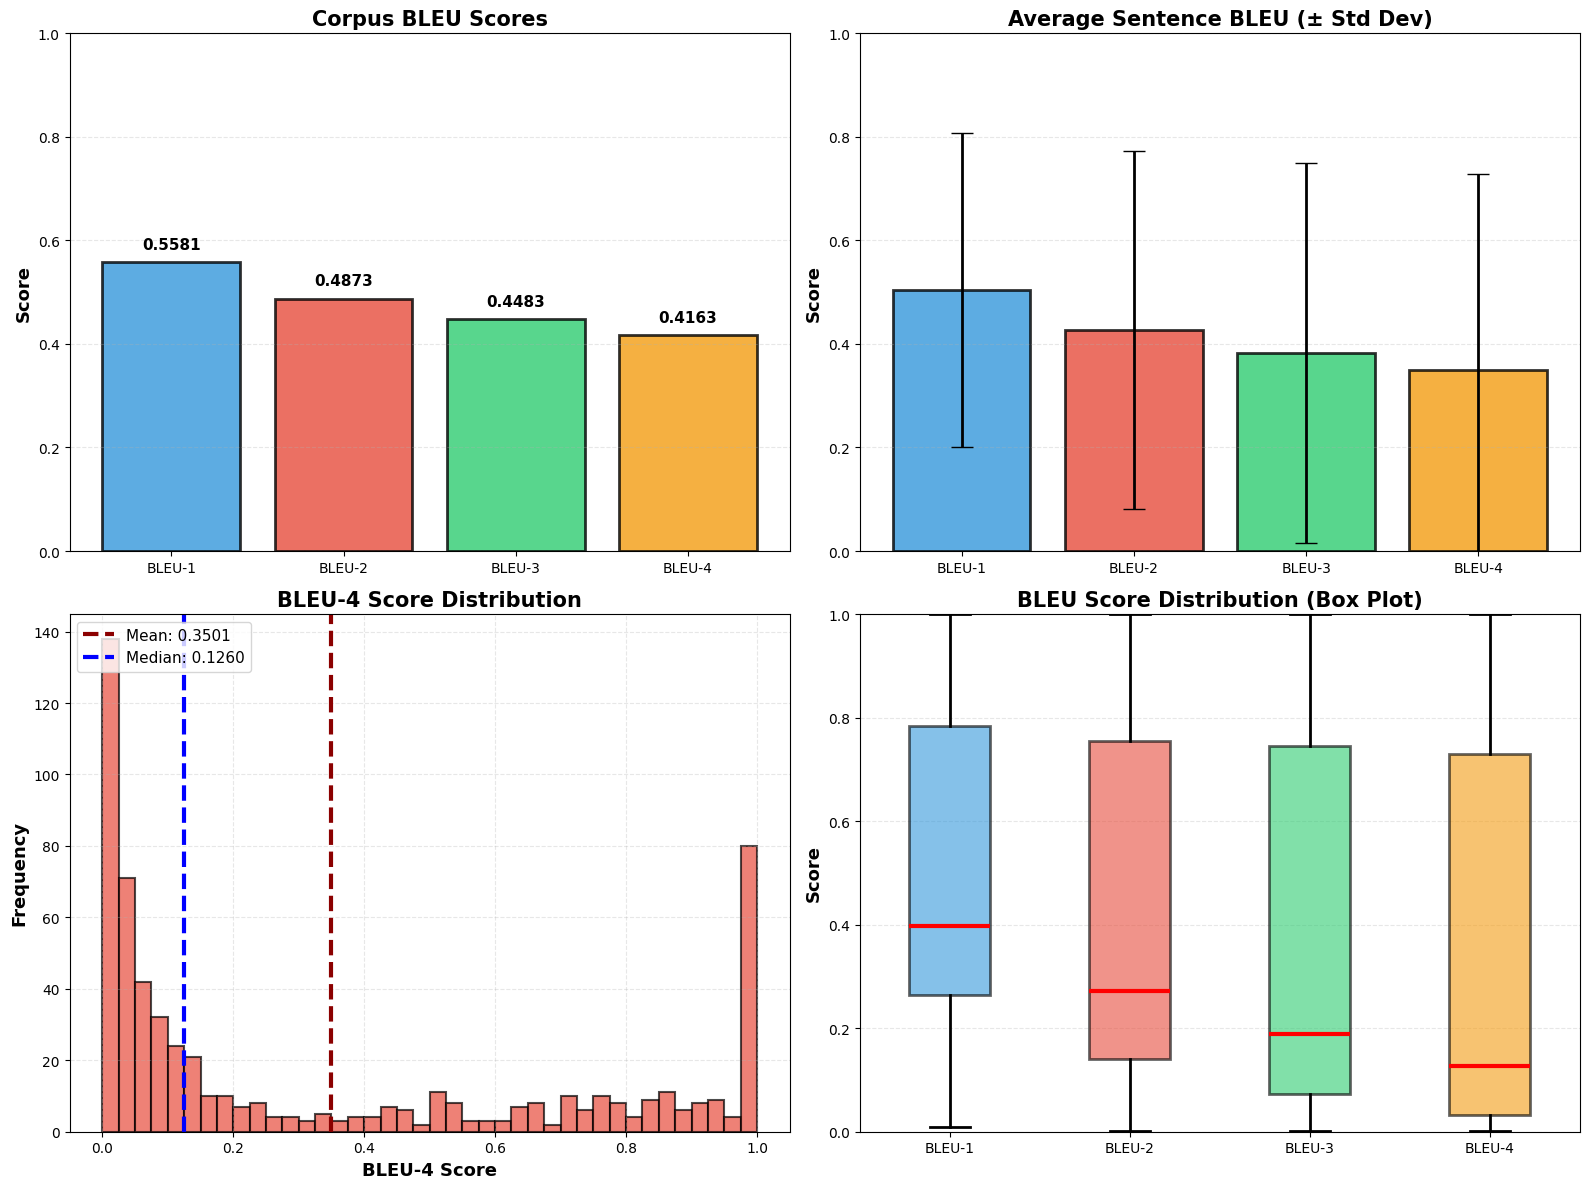


✓ BLEU SCORE CALCULATION COMPLETED!


In [ ]:
"""
Calculate BLEU scores for all test samples
"""

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
import nltk
nltk.download('punkt', quiet=True)

print("="*80)
print("CALCULATING BLEU SCORES ON TEST SET")
print("="*80)

# Store all references and hypotheses
references = []
hypotheses = []
bleu_details = []

print(f"\nGenerating reports for {len(test_df)} test samples...")
print("This will take a few minutes on CPU...\n")

for idx in tqdm(range(len(test_df))):
    row = test_df.iloc[idx]
    img_path = row['image_path_enhanced']
    ground_truth = row['report']
    problem = row['Problems']

    # Generate report
    _, generated_report = generate_report(model, img_path, tokenizer, device)

    # Tokenize for BLEU
    reference_tokens = ground_truth.strip().split()
    hypothesis_tokens = generated_report.strip().split()

    references.append([reference_tokens])
    hypotheses.append(hypothesis_tokens)

    # Store details
    bleu_details.append({
        'problem': problem,
        'generated': generated_report,
        'ground_truth': ground_truth,
        'ref_len': len(reference_tokens),
        'hyp_len': len(hypothesis_tokens)
    })

# Calculate individual BLEU scores
smoothing = SmoothingFunction().method1

print("\nCalculating individual BLEU scores...")

bleu1_scores = []
bleu2_scores = []
bleu3_scores = []
bleu4_scores = []

for ref, hyp in tqdm(zip(references, hypotheses), total=len(references)):
    b1 = sentence_bleu(ref, hyp, weights=(1, 0, 0, 0), smoothing_function=smoothing)
    b2 = sentence_bleu(ref, hyp, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing)
    b3 = sentence_bleu(ref, hyp, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing)
    b4 = sentence_bleu(ref, hyp, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)

    bleu1_scores.append(b1)
    bleu2_scores.append(b2)
    bleu3_scores.append(b3)
    bleu4_scores.append(b4)

# Calculate corpus BLEU
print("\nCalculating corpus BLEU scores...")

corpus_bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
corpus_bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
corpus_bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
corpus_bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

# Display results
print("\n" + "="*80)
print("BLEU SCORE RESULTS")
print("="*80)

print("\n📊 CORPUS BLEU SCORES (Overall Model Performance):")
print("="*80)
print(f"  BLEU-1: {corpus_bleu1:.4f} ({corpus_bleu1*100:.2f}%)")
print(f"  BLEU-2: {corpus_bleu2:.4f} ({corpus_bleu2*100:.2f}%)")
print(f"  BLEU-3: {corpus_bleu3:.4f} ({corpus_bleu3*100:.2f}%)")
print(f"  BLEU-4: {corpus_bleu4:.4f} ({corpus_bleu4*100:.2f}%)")

print("\n📊 AVERAGE SENTENCE BLEU SCORES:")
print("="*80)
print(f"  BLEU-1: {np.mean(bleu1_scores):.4f} ± {np.std(bleu1_scores):.4f}")
print(f"  BLEU-2: {np.mean(bleu2_scores):.4f} ± {np.std(bleu2_scores):.4f}")
print(f"  BLEU-3: {np.mean(bleu3_scores):.4f} ± {np.std(bleu3_scores):.4f}")
print(f"  BLEU-4: {np.mean(bleu4_scores):.4f} ± {np.std(bleu4_scores):.4f}")

print("\n📊 BLEU-4 STATISTICS:")
print("="*80)
print(f"  Min:     {np.min(bleu4_scores):.4f}")
print(f"  25th %:  {np.percentile(bleu4_scores, 25):.4f}")
print(f"  Median:  {np.median(bleu4_scores):.4f}")
print(f"  75th %:  {np.percentile(bleu4_scores, 75):.4f}")
print(f"  Max:     {np.max(bleu4_scores):.4f}")

# Length statistics
print("\n📊 LENGTH STATISTICS:")
print("="*80)
avg_ref_len = np.mean([d['ref_len'] for d in bleu_details])
avg_hyp_len = np.mean([d['hyp_len'] for d in bleu_details])
print(f"  Avg Reference Length:  {avg_ref_len:.1f} words")
print(f"  Avg Generated Length:  {avg_hyp_len:.1f} words")
print(f"  Length Ratio:          {avg_hyp_len/avg_ref_len:.2f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Corpus BLEU Bar Chart
bleu_types = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']
corpus_scores = [corpus_bleu1, corpus_bleu2, corpus_bleu3, corpus_bleu4]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

bars = axes[0, 0].bar(bleu_types, corpus_scores, color=colors,
                       edgecolor='black', linewidth=2, alpha=0.8)
axes[0, 0].set_ylabel('Score', fontsize=13, weight='bold')
axes[0, 0].set_title('Corpus BLEU Scores', fontsize=15, weight='bold')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(True, alpha=0.3, axis='y', linestyle='--')

for i, (bar, score) in enumerate(zip(bars, corpus_scores)):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{score:.4f}',
                    ha='center', va='bottom', fontsize=11, weight='bold')

# 2. Average Sentence BLEU with Error Bars
avg_scores = [np.mean(bleu1_scores), np.mean(bleu2_scores),
              np.mean(bleu3_scores), np.mean(bleu4_scores)]
std_scores = [np.std(bleu1_scores), np.std(bleu2_scores),
              np.std(bleu3_scores), np.std(bleu4_scores)]

axes[0, 1].bar(bleu_types, avg_scores, yerr=std_scores,
               color=colors, edgecolor='black', linewidth=2,
               alpha=0.8, capsize=8, error_kw={'linewidth': 2})
axes[0, 1].set_ylabel('Score', fontsize=13, weight='bold')
axes[0, 1].set_title('Average Sentence BLEU (± Std Dev)', fontsize=15, weight='bold')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(True, alpha=0.3, axis='y', linestyle='--')

# 3. BLEU-4 Distribution Histogram
axes[1, 0].hist(bleu4_scores, bins=40, color='#e74c3c',
                edgecolor='black', alpha=0.7, linewidth=1.5)
axes[1, 0].axvline(np.mean(bleu4_scores), color='darkred',
                   linestyle='--', linewidth=3,
                   label=f'Mean: {np.mean(bleu4_scores):.4f}')
axes[1, 0].axvline(np.median(bleu4_scores), color='blue',
                   linestyle='--', linewidth=3,
                   label=f'Median: {np.median(bleu4_scores):.4f}')
axes[1, 0].set_xlabel('BLEU-4 Score', fontsize=13, weight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=13, weight='bold')
axes[1, 0].set_title('BLEU-4 Score Distribution', fontsize=15, weight='bold')
axes[1, 0].legend(fontsize=11, loc='upper left')
axes[1, 0].grid(True, alpha=0.3, linestyle='--')

# 4. Box Plot Comparison
bleu_data = [bleu1_scores, bleu2_scores, bleu3_scores, bleu4_scores]
bp = axes[1, 1].boxplot(bleu_data, labels=bleu_types, patch_artist=True,
                        boxprops=dict(facecolor='lightblue', alpha=0.7, linewidth=2),
                        medianprops=dict(color='red', linewidth=3),
                        whiskerprops=dict(linewidth=2),
                        capprops=dict(linewidth=2))

# Color boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[1, 1].set_ylabel('Score', fontsize=13, weight='bold')
axes[1, 1].set_title('BLEU Score Distribution (Box Plot)', fontsize=15, weight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y', linestyle='--')
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ BLEU SCORE CALCULATION COMPLETED!")
print("="*80)

In [ ]:
"""
Analyze best and worst performing examples
"""

# Sort by BLEU-4
bleu4_array = np.array(bleu4_scores)
sorted_indices = np.argsort(bleu4_array)

# Get top 3 and bottom 3
best_indices = sorted_indices[-3:][::-1]
worst_indices = sorted_indices[:3]

print("="*80)
print("TOP 3 BEST EXAMPLES (Highest BLEU-4)")
print("="*80)

for rank, idx in enumerate(best_indices, 1):
    detail = bleu_details[idx]
    score = bleu4_scores[idx]

    print(f"\n{'='*80}")
    print(f"RANK #{rank} - BLEU-4: {score:.4f}")
    print(f"{'='*80}")
    print(f"Problem: {detail['problem']}")
    print(f"\n[GENERATED] ({detail['hyp_len']} words):")
    print(f"{detail['generated']}")
    print(f"\n[GROUND TRUTH] ({detail['ref_len']} words):")
    print(f"{detail['ground_truth']}")

print("\n\n" + "="*80)
print("TOP 3 WORST EXAMPLES (Lowest BLEU-4)")
print("="*80)

for rank, idx in enumerate(worst_indices, 1):
    detail = bleu_details[idx]
    score = bleu4_scores[idx]

    print(f"\n{'='*80}")
    print(f"RANK #{rank} - BLEU-4: {score:.4f}")
    print(f"{'='*80}")
    print(f"Problem: {detail['problem']}")
    print(f"\n[GENERATED] ({detail['hyp_len']} words):")
    print(f"{detail['generated']}")
    print(f"\n[GROUND TRUTH] ({detail['ref_len']} words):")
    print(f"{detail['ground_truth']}")

TOP 3 BEST EXAMPLES (Highest BLEU-4)

RANK #1 - BLEU-4: 1.0000
Problem: Nodule;Granuloma;Calcinosis

[GENERATED] (58 words):
the examination consists of frontal and lateral radiographs of the chest. the cardiomediastinal contours are unchanged. pulmonary vascularity is within normal limits. calcified right upper lobe nodule with a granuloma is again seen but unchanged. no focal consolidation, pleural effusion, or pneumothorax identified. the visualized osseous structures and upper abdomen are unremarkable. no evidence of acute cardiopulmonary process

[GROUND TRUTH] (58 words):
the examination consists of frontal and lateral radiographs of the chest. the cardiomediastinal contours are unchanged. pulmonary vascularity is within normal limits. calcified right upper lobe nodule with a granuloma is again seen but unchanged. no focal consolidation, pleural effusion, or pneumothorax identified. the visualized osseous structures and upper abdomen are unremarkable. no evidence of acute cardiop

In [ ]:
"""
Save all results to Google Drive
"""

results_dir = os.path.join(BASE_DIR, 'results')
os.makedirs(results_dir, exist_ok=True)

# Save BLEU scores
with open(os.path.join(results_dir, 'bleu_scores_final.txt'), 'w') as f:
    f.write("="*80 + "\n")
    f.write("FINAL BLEU SCORES - MEDICAL REPORT GENERATION\n")
    f.write("="*80 + "\n\n")

    f.write(f"Model: Transformer (DenseNet121 + 6-layer Decoder)\n")
    f.write(f"Epoch: {checkpoint['epoch']}\n")
    f.write(f"Val Loss: {checkpoint['val_loss']:.4f}\n")
    f.write(f"Test Samples: {len(test_df)}\n\n")

    f.write("="*80 + "\n")
    f.write("CORPUS BLEU SCORES:\n")
    f.write("="*80 + "\n")
    f.write(f"BLEU-1: {corpus_bleu1:.4f} ({corpus_bleu1*100:.2f}%)\n")
    f.write(f"BLEU-2: {corpus_bleu2:.4f} ({corpus_bleu2*100:.2f}%)\n")
    f.write(f"BLEU-3: {corpus_bleu3:.4f} ({corpus_bleu3*100:.2f}%)\n")
    f.write(f"BLEU-4: {corpus_bleu4:.4f} ({corpus_bleu4*100:.2f}%)\n\n")

    f.write("="*80 + "\n")
    f.write("AVERAGE SENTENCE BLEU:\n")
    f.write("="*80 + "\n")
    f.write(f"BLEU-1: {np.mean(bleu1_scores):.4f} ± {np.std(bleu1_scores):.4f}\n")
    f.write(f"BLEU-2: {np.mean(bleu2_scores):.4f} ± {np.std(bleu2_scores):.4f}\n")
    f.write(f"BLEU-3: {np.mean(bleu3_scores):.4f} ± {np.std(bleu3_scores):.4f}\n")
    f.write(f"BLEU-4: {np.mean(bleu4_scores):.4f} ± {np.std(bleu4_scores):.4f}\n\n")

    f.write("="*80 + "\n")
    f.write("BLEU-4 DISTRIBUTION:\n")
    f.write("="*80 + "\n")
    f.write(f"Min:     {np.min(bleu4_scores):.4f}\n")
    f.write(f"25th %:  {np.percentile(bleu4_scores, 25):.4f}\n")
    f.write(f"Median:  {np.median(bleu4_scores):.4f}\n")
    f.write(f"75th %:  {np.percentile(bleu4_scores, 75):.4f}\n")
    f.write(f"Max:     {np.max(bleu4_scores):.4f}\n")

print(f"✓ Results saved to: {results_dir}/bleu_scores_final.txt")
print("\n✓ EVALUATION COMPLETE! 🎉")

✓ Results saved to: /content/drive/MyDrive/MedicalReportGenerator/results/bleu_scores_final.txt

✓ EVALUATION COMPLETE! 🎉
